In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import library yang akan digunakan
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from datetime import date, timedelta
plt.style.use('fivethirtyeight')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
import warnings

In [3]:
# mengimport dataset yang akan digunakan
train = pd.read_csv('/content/drive/MyDrive/Dataset/train.csv',index_col=0)

# mengubah type data kolom date
train['date'] = pd.to_datetime(train.date)

# Mengatur kolom tanggal sebagai indeks data
train.set_index('date', inplace=True)

# Meresample data harian menjadi bulanan dengan rata-rata
data_mingguan = train.resample('W').mean()

data_mingguan.head()

<ipython-input-3-fd2562f51592>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_mingguan = train.resample('W').mean()


,store_nbr,sales,onpromotion
date,,,
2013-01-06,27.5,206.843478,0.0
2013-01-13,27.5,190.285220,0.0
2013-01-20,27.5,189.835452,0.0
2013-01-27,27.5,182.152050,0.0
2013-02-03,27.5,198.564267,0.0


<ipython-input-4-8ecd173022be>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_ =train.corr()


<Axes: >

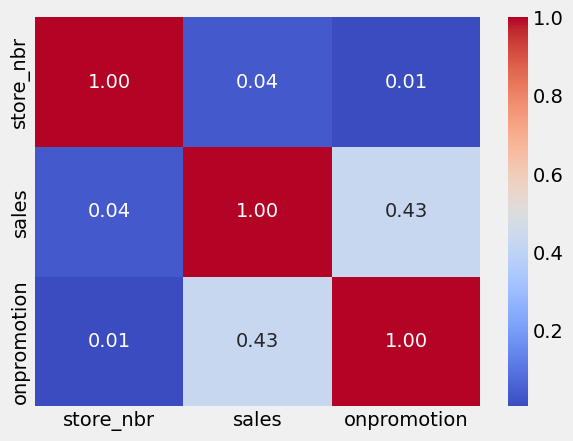

In [4]:
import seaborn as sns
train_ =train.corr()
sns.heatmap(train_, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)

In [5]:
data_mingguan= data_mingguan.reset_index()
data_mingguan.sample(3)

,date,store_nbr,sales,onpromotion
214,2017-02-12,27.5,457.435407,5.873096
178,2016-06-05,27.5,489.893843,6.098445
70,2014-05-11,27.5,237.199266,0.082732


In [6]:
data_mingguan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         242 non-null    datetime64[ns]
 1   store_nbr    242 non-null    float64       
 2   sales        242 non-null    float64       
 3   onpromotion  242 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 7.7 KB


In [7]:
data_mingguan = data_mingguan.drop(columns=['store_nbr'],axis=1)

In [8]:
data_mingguan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         242 non-null    datetime64[ns]
 1   sales        242 non-null    float64       
 2   onpromotion  242 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 5.8 KB


data terdiri dari 5 kolom dan 3000888 baris
terdapat kolom date sebagai tanggal, store_nbr sebagai store penjualan
kolom family merupakan keluarga yang memproduksi, sales adalah jumlah penjualan
yang setiap baris berisi satu transaksi penjualan dan onpromotion
kolom date berisi waktu perhari (daily). Untuk mempermudah analisa saya melakukan resampling data ke mingguan


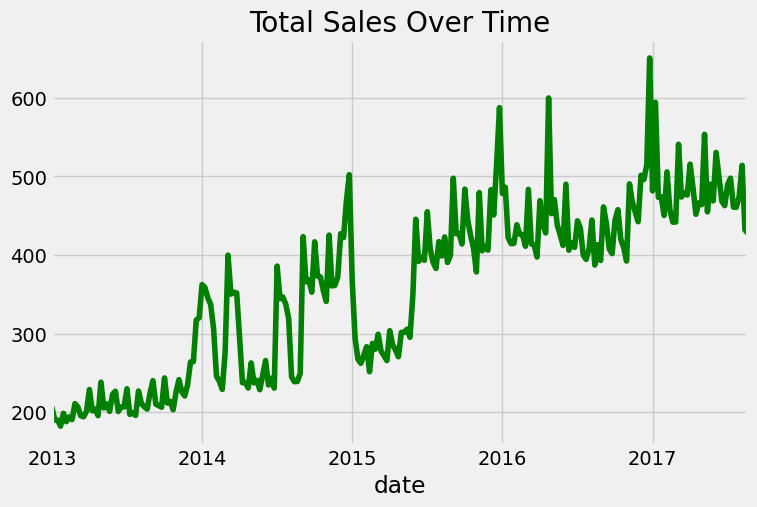

In [9]:
# melihat pendapat penjualan perhari
plt.figure(figsize=(8,5))
data_mingguan.groupby('date')['sales'].sum().plot(color='green')
plt.title('Total Sales Over Time')
plt.show()

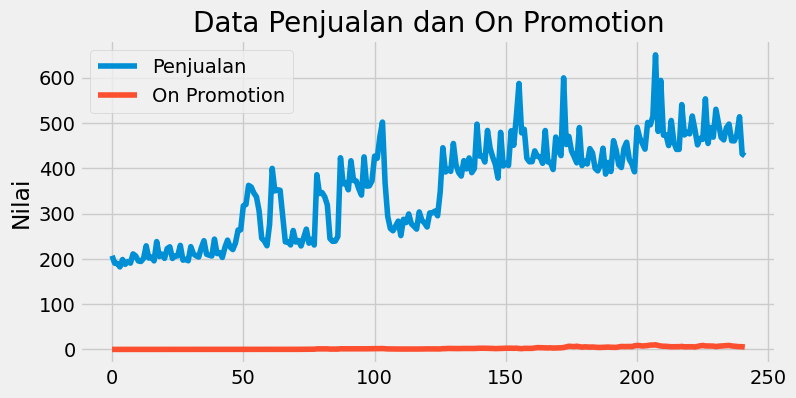

In [11]:
plt.figure(figsize=(8, 4))
plt.plot(data_mingguan['sales'], label='Penjualan')
plt.plot(data_mingguan['onpromotion'], label='On Promotion')
plt.ylabel('Nilai')
plt.title('Data Penjualan dan On Promotion')
plt.legend()
plt.show()


<Figure size 640x480 with 0 Axes>

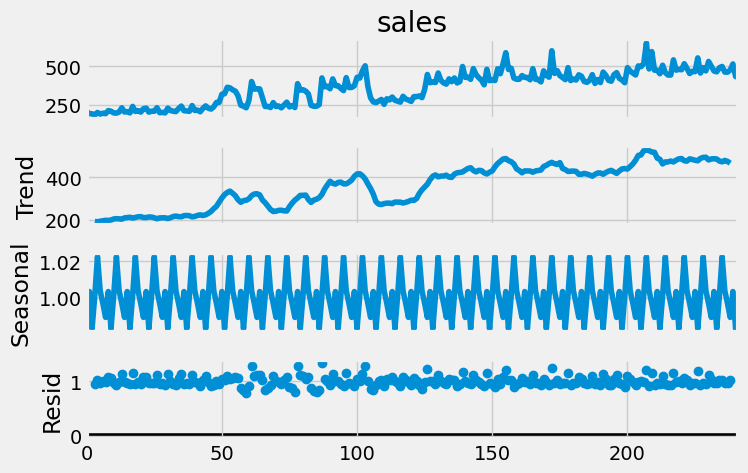

In [12]:
# Penjualan naik turun mengikuti trend kenaikan, masuk kategori seasonal
# tapi kita cek dulu menggunakan grafik
# periode 7 adalah periode selama 7 hari
result = seasonal_decompose(data_mingguan['sales'], model='multiplicative', period=7)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(8,5)

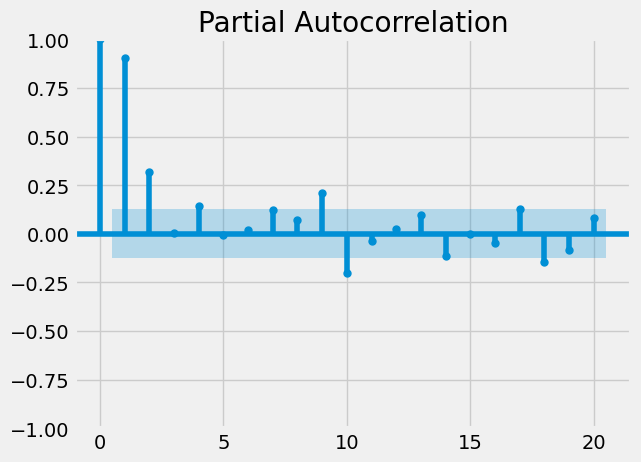

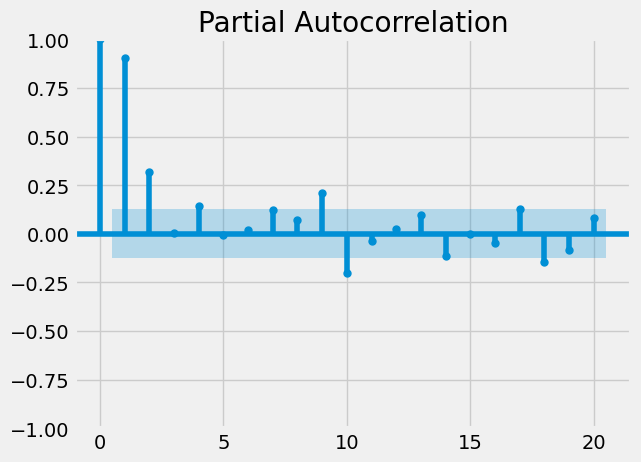

In [14]:
# bener data yang dimiliki merupakan seasonal makan nilai d = 0
# mencari nilai q dengan menggunakan autokorelation parcial
# nilai q = 1
plot_pacf(data_mingguan['sales'],lags=20)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

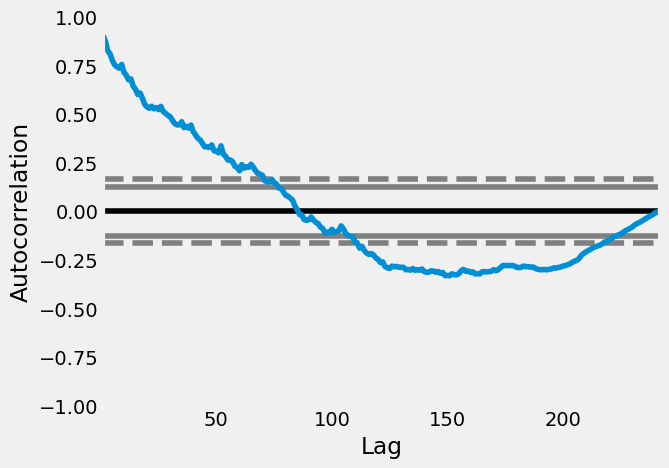

In [17]:
# mencari nilai p dengan menggunakan autocorelation
# didapat nilai p = 8
pd.plotting.autocorrelation_plot(data_mingguan['sales'])

In [20]:
# maka model yang akan digunakan adalah sarimax,
# karena terdapat hub korelasi antara kolom sales dengan onpromotion
d = 0
p = 8
q = 1

exog_feature = data_mingguan['onpromotion']

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# membuat model sarimax
model = SARIMAX(data_mingguan['sales'],
                order =(p,d,q),
                seasonal_order =(p,d,q, 12))
# melatih model
model = model.fit()
print(model.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              sales   No. Observations:                  242
Model:             SARIMAX(8, 0, 1)x(8, 0, 1, 12)   Log Likelihood               -1231.798
Date:                            Wed, 04 Oct 2023   AIC                           2501.597
Time:                                    06:40:14   BIC                           2567.886
Sample:                                         0   HQIC                          2528.301
                                            - 242                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2440      0.123     -1.983      0.047      -0.485      -0.003
ar.L2          0.8305      0.095   

In [39]:
# melakukan perkiraan penjualan 1 tahun kedepan
predictions = model.predict(len(data_mingguan),len(data_mingguan)+60)
print(predictions)

242    422.563903
243    423.176610
244    427.014708
245    438.914882
246    447.038341
          ...    
298    400.087528
299    412.204596
300    426.876502
301    418.790564
302    416.912647
Name: predicted_mean, Length: 61, dtype: float64


<Axes: >

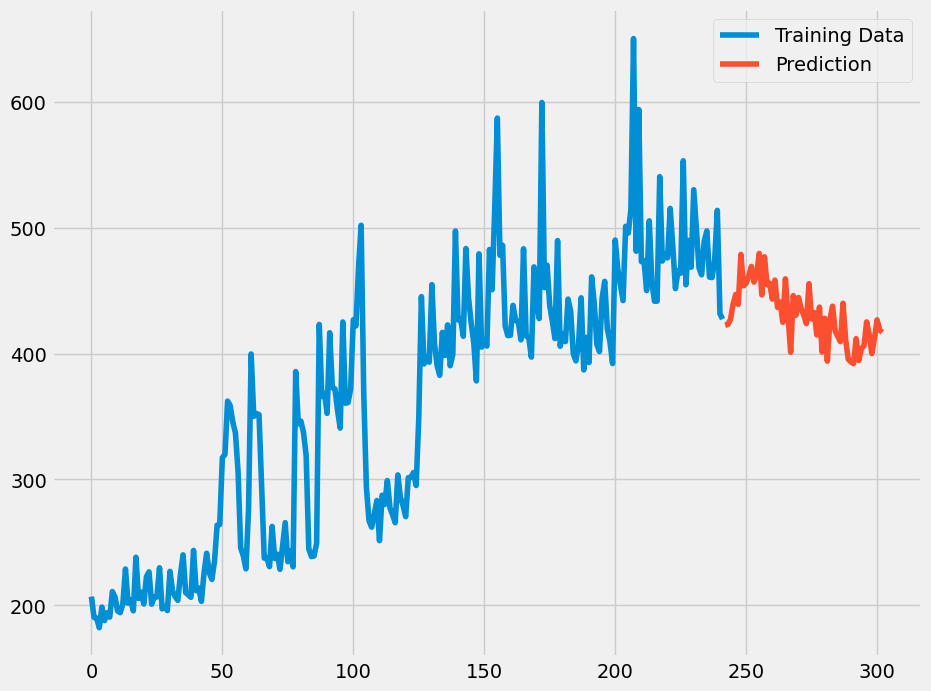

In [40]:
#untuk mempermudah membaca hasil menggunakan grafik
data_mingguan['sales'].plot(legend=True,
                    label ='Training Data',
                    figsize =(10,8))
predictions.plot(legend=True, label='Prediction')